In [1]:
import math 
from mpl_toolkits.mplot3d import Axes3D #noqa

import matplotlib.pyplot as plt
from collections import Counter 
from sympy import *
import numpy as np
%matplotlib notebook 

#SURFACE Parent class - keeps track of the common attributes and methods each surface has 
class Surface:
    def __init__(self, rc, vertex, n): #parameters taken: radius curvature, vertex, index of refraction
        self.rc = rc
        self.vertex = vertex
        self.n = n
        
#SPHERE - child of SURFACE, used for the graphing the spherical lens 
class Sphere(Surface):
    def __init__(self, rc, vertex, orient, n, pol_angle_max):
        super().__init__(rc, vertex, n)
        self.orient = orient #either 1 or -1 - orientation of the sphere i.e. '(' or ')''
        self.pol_angle_max = pol_angle_max #the angle "theta" in spherical coordinates - angle with z-axis
        self.lens_index = None #keeping track of which surfaces making up the same physical object 
        
    #to get coordinates of the center 
    def get_center_coords(self): 
        center_coords = [self.vertex[0], self.vertex[1], self.vertex[2]-self.orient*self.rc]
        return center_coords 
    
    #to get the point on the sphere 
    def eval_eq(self, x, y): #Parameters - x and y coordinates on the sphere 
        coords = self.get_center_coords()
        #equation: z = z0 +/- sqrt(R^2 - (x-x0)^2 - (y-y0)^2)
        z = coords[2] + self.orient*np.sqrt(self.rc**2 - (x-coords[0])**2 - (y-coords[1])**2)
        return [x, y, z]
    
    #to get the components of the normal unit vector at a point on the sphere 
    def get_norm_dir(self, xy_coords): 
        norm_dirs = []
        for n in range(0,3): #running through the x, y and z coords stoired in 0, 1, 2 index 
            #equation: Unit_normal_vector = [(positiion vector of point on sphere) - (position vector of origin)]/(Radius)
            if n == 2:
                norm_dirs.append(abs((self.eval_eq(xy_coords[0], xy_coords[1])[2]-self.get_center_coords()[2])/self.rc))
            else:
                norm_dirs.append((xy_coords[n]-self.get_center_coords()[n])*self.orient/self.rc)
        
        return norm_dirs
    
    #to get the arrays needed to plot the surface 
    def get_sphere_plot_coords(self):
        #surface treated as a sphere if radius is less than 1000
        if self.rc < 1000:
            theta = np.linspace(0, self.pol_angle_max, 1000)
            phi = np.linspace(0, 2*np.pi, 1000)
            mesh_theta, mesh_phi = np.meshgrid(theta, phi)
            
            #on RHS - R*sin(theta)*cos(phi), R*sin(theta)*sin(phi), z0 + R*cos(theta)
            x,y,z  = self.rc*self.orient*np.sin(mesh_theta)*np.cos(mesh_phi), self.rc*np.sin(mesh_theta)*\
                     np.sin(mesh_phi), self.get_center_coords()[2]+self.rc*self.orient*np.cos(mesh_theta)
            return [x, y, z]
        #surface treated as a plane if radius > 1000
        else:
            z = self.vertex[2]
            x = np.linspace(-2.54/2, 2.54/2, 1000)
            y = x
            
            x_mesh, y_mesh = np.meshgrid(x,y)
            
            return [x_mesh, y_mesh, z]
        
        #***************************************************************************************************#

In [2]:
class Ray:
    max_surf_occurences = 3 #limit how many surface's information to hold 
    
    def __init__(self, ini_coords, ini_dirs, bounds): #Parameters: initial coordinates, directions, bounds of sim space
        self.coords = [ini_coords]
        self.dirs = [ini_dirs]
        self.bounds = bounds #the bounds of the simulation space 
        self.surfs_intersected = [] #keeping track of surfaces intersected 
        self.prev_surfs = [] #surfaces intersected by rays that this ray came from 
        self.t = []
        
     
    def get_coords_at_t(self, t):  # Evaluates ray's parametric equations at t
        coords_at_t = []
        #FORMULA - basically [ray at t = initial-coords + t*direction-vector ]
        for n in range(0, 3):
            coords_at_t.append(t * self.dirs[len(self.dirs)-1][n] + self.coords[len(self.coords)-1][n])  # Each row is
            # a coord, so the columns are the coords along an axis
        return coords_at_t
        
    def reflect (self, norm_dir): #Returns the reflected direction 
        #SIGN OF GAMMA - fixes the z-direction sign when ray's direction is different = r/|r|
        sign_of_gamma = self.dirs[len(self.dirs)-1][2]/abs(self.dirs[len(self.dirs)-1][2])
        #FORMULA - new_norm_dir = (sign of gamma)*(n = vector that is normal to the surface at point of instersection)
        new_norm_dir = [d*sign_of_gamma for d in norm_dir]
        #COSTERM in finding the new direction vector of reflected ray = (2/n0)*cos(theta)
        cos_term = 2*np.dot(self.dirs[len(self.dirs)-1], new_norm_dir)
        #FIRST TERM - the initial direction of the ray 
        first_term = self.dirs[len(self.dirs)-1]
        #SECOND TERM - COSTERM with the n-vector 
        second_term = [d*cos_term for d in new_norm_dir]

        new_dirs = [s - n for s, n in zip(first_term, second_term)]  # Array that gets the difference between the
        # entries in the first_term and second_term array
        
        return new_dirs 
    
    def refract(self, n0, n, norm_dir):  # Returns the refracted directions
        #Sign of gamma = vector-r / modulus(vector-r)
        sign_of_gamma = self.dirs[len(self.dirs) - 1][2] / abs(self.dirs[len(self.dirs) - 1][2])
        #New Normal Direction. - fixing the normal vector to the correct orientation 
        new_norm_dir = [d * sign_of_gamma for d in norm_dir]
        #######COMPONENTS OF THE EQUATION FOR THE NEW DIR###########
        n0_cos = n0*np.dot(self.dirs[len(self.dirs)-1], new_norm_dir)
        #print(n**2-n0**2+n0_cos**2)
        n_cos = math.sqrt(n**2-n0**2+n0_cos**2)
        refrac_ratio = n0/n
        sec_term_coeff = (n_cos-n0_cos)/n

        first_term = [d*refrac_ratio for d in self.dirs[len(self.dirs)-1]]
        second_term = [norm*sec_term_coeff for norm in new_norm_dir]

        new_dirs = [s + n for s, n in zip(first_term, second_term)]  # Array that gets the sum between the
        # entries in the first_term and second_term array

        self.dirs.append(new_dirs)
        
#**************************************Note: check for redundancy********************************#      
    def translate(self, surfs):  # Translates the ray to a surface or to a boundary point
        t = self.find_min_t(surfs)
        if t != 0:
            self.t.append(t)
            self.add_coord(self.get_coords_at_t(t))
        else:
            self.translate_to_nearest_bound()
            
    def find_t_nearest_bound(self):  # Finds minimum t value that makes ray intersect a boundary point
        dirs = self.dirs[len(self.dirs)-1]
        ray_coords = self.coords[len(self.coords)-1]
        t_vals = []

        for i in range(0, len(self.bounds)):
            for j in range(0, len(self.bounds[0])):
                if dirs[i] != 0:
                    t_vals.append((self.bounds[i][j] - ray_coords[i])/dirs[i])

        if len(t_vals) > 0:
            return float(min(i for i in t_vals if i > 0))  # Returns smallest t value for ray to go to nearest boundary
            # point

        return 0
    
    def translate_to_nearest_bound(self):  # Translates to nearest boundary point
        t = self.find_t_nearest_bound()
        if t != 0:
            self.add_coord(self.get_coords_at_t(t))
            
    def dif_bet_coords(self, coords1, coords2):  # Checks if two points are similar enough to be considered the same
        dif_bet_coords = [abs(a - b) for a, b in zip(coords1, coords2)]

        for coord_dif in dif_bet_coords:
            if coord_dif > 10 ** -4:  # If the difference between coords is less than 10^-4, its basically zero,
                # so the two coords are the same. If greater, then it's not
                return False

        return True

    def coord_check(self, ray_coords, surf):  # Checks if the coord at t value actually corresponds to a point on the
        # surface
        root = surf.rc**2-(ray_coords[0]-surf.get_center_coords()[0])**2-(ray_coords[1]-surf.get_center_coords()[1])**2
        is_positive = True if root >= 0 else False  # Avoids negatives under square roots

        if is_positive:
            surf_coords = surf.eval_eq(ray_coords[0], ray_coords[1])
            return self.dif_bet_coords(ray_coords, surf_coords)

        return False
    
    def find_min_t(self, surfs):  # Finds minimum t value that allows ray to intersect nearest surface
        t_vals = []  # Holds values of t for each surface intersected by ray
        t_indices = []  # Parallel array that keeps track of the index of the surface with corresponding t value in
        # t_vals
        loop_index = 0  # Keeps track of the amount of loops/index of surf array

        for surf in surfs:
            t = self.solve_t(surf)  # t value obtained for a given surface
            lies_on_surf = self.coord_check(self.get_coords_at_t(t), surf)  # Checks if t value does allow the ray to
            # intersect the surface it's supposed to intersect

            #print(lies_on_surf)

            if t != 0 and lies_on_surf:  # If t value is valid, we store it
                t_vals.append(t)
                t_indices.append(loop_index)

            loop_index += 1  # Increments the loop_index because we're moving on to the next surface in the list

        if len(t_vals) > 0:  # If the surface did intersect surfaces, we want to get the closest one (get the smallest
            # t)
            min_t = min(t_vals)
            index_of_min = t_vals.index(min_t)
            #same_as_past_coord = self.dif_bet_coords(self.get_coords_at_t(min_t), self.coords[len(self.coords)-1])

            #if not same_as_past_coord:
            self.surfs_intersected.append(surfs[t_indices[index_of_min]])

            return min(t_vals)

        return 0
    
    def solve_t(self, surf):  # Solving for t for one surface
        x, y, z = surf.get_center_coords()[0], surf.get_center_coords()[1], surf.get_center_coords()[2]
        rc = surf.rc

        last_dir_pos = len(self.dirs)-1
        last_coords_pos = len(self.coords)-1
        
        x0 = self.coords[last_coords_pos][len(self.coords[last_coords_pos])-3]
        y0 = self.coords[last_coords_pos][len(self.coords[last_coords_pos])-2]
        z0 = self.coords[last_coords_pos][len(self.coords[last_coords_pos])-1]

        alpha = self.dirs[last_dir_pos][len(self.dirs[last_dir_pos])-3]
        beta = self.dirs[last_dir_pos][len(self.dirs[last_dir_pos])-2]
        gamma = self.dirs[last_dir_pos][len(self.dirs[last_dir_pos])-1]

        fac1, fac2, fac3 = x0-x, y0-y, z0-z

        sign_of_gamma = gamma/abs(gamma)

        a = 1
        b = 2*(alpha*fac1+beta*fac2+gamma*fac3)
        c = fac1**2+fac2**2+fac3**2-rc**2

        discriminant = b**2-4*a*c

        if discriminant >= 0:
            t = (-b+sign_of_gamma*surf.orient*math.sqrt(discriminant))/2*a

            if t > 10**-3:
                return t

        return 0

    def add_coord(self, coords):
        self.coords.append(coords)

    def add_dir(self, dirs):
        self.dirs.append(dirs)

    def get_ray_coords(self):  # Sets up the coordinates of the ray in the form needed to plot the ray
        x, y, z = [], [], []

        for row in range(0, len(self.coords)):
            x.append(self.coords[row][0])
            y.append(self.coords[row][1])
            z.append(self.coords[row][2])

        return [x, y, z]
    
    
    def within_lens(self, lenses):  # Checks if ray is between two surfaces that make up a lens
        if len(self.prev_surfs) > 0 and len(self.surfs_intersected) == 1:  # The case where the ray is a reflected ray and
            # originated from a surface that is part of a lens and has translated to a surface that is part of that same
            # lens
            surf_intersected = self.surfs_intersected[0]
            prev_surf = self.prev_surfs[len(self.prev_surfs)-1]
            if surf_intersected.lens_index == prev_surf.lens_index:  # Checks to see if the surfaces make up a lens
                return True
            return False

        elif len(self.surfs_intersected) > 1 and len(self.prev_surfs) > 0:  # The case where the ray was originally a
            # reflected ray, and has intersected multiple surfaces
            surf_intersected = self.surfs_intersected[len(self.surfs_intersected) - 1]
            prev_surf = self.surfs_intersected[len(self.surfs_intersected) - 2]
            if surf_intersected.lens_index == prev_surf.lens_index:  # Checks to see if the surfaces make up a lens
                return True
            return False

        elif len(self.surfs_intersected) > 1:  # The case where the ray is a source ray
            surf_intersected = self.surfs_intersected[len(self.surfs_intersected) - 1]
            prev_surf = self.surfs_intersected[len(self.surfs_intersected) - 2]
            if surf_intersected.lens_index == prev_surf.lens_index:  # Checks to see if surfaces make up a lens
                return True
            return False
        return False
    
         #***************************************************************************************************#      

In [3]:
class Simulation:

    refrac_index = 1  # Index of refraction of the simulation space

    def __init__(self, space):
        self.surfs = []  # Array of surface objects
        self.lenses = [[], []]  # Array of lens objects
        self.sources = []  # Array of sources/rays
        self.space = space  # Array of boundary lines
        self.ax = self.plot()  # Plotting object

    def add_surf(self, rc, vertex, orient, n, pol_angle):  # Adds surface to surfs array of the Simulation instance
        self.surfs.append(Sphere(rc, vertex, orient, n, pol_angle))

    def add_converging_lens(self, surf1, surf2):  # Adds Converging lens to lenses array of Simulation object
        self.lenses[0].append([surf1, surf2])  # Adds converging lens to first array of lenses array
        self.surfs.append(surf1)  # Adds surface to surfs array of the Simulation instance
        self.surfs.append(surf2)  # Adds surface to surfs array of the Simulation instance
        surf1.lens_index, surf2.lens_index = -1*len(self.lenses[0]), -1*len(self.lenses[0])  # Assigning the surfaces a
        # lens index, which makes one able to keep track of which surfaces belong to a physical object (in this case a
        # lens)

    def add_diverging_lens(self, surf1, surf2):   # Adds Diverging lens to lenses array of Simulation object
        self.lenses[1].append([surf1, surf2])  # Adds diverging lens to first array of lenses array
        self.surfs.append(surf1)  # Adds surface to surfs array of the Simulation instance
        self.surfs.append(surf2)  # Adds surface to surfs array of the Simulation instance
        surf1.lens_index, surf2.lens_index = len(self.lenses[1]), len(self.lenses[1])

    def add_ray(self, initial_coords, angles):  # Adds ray to sources array of the Simulation instance
        self.sources.append(Ray(initial_coords, self.angles_to_dirs(angles), self.space))

    def get_space_coords(self):  # Returns space array that will be used to plot the Simulation space
        x = np.linspace(self.space[0][0], self.space[0][1], 1000)
        y = np.linspace(self.space[1][0], self.space[1][1], 1000)

        return [x, y]

    def get_mesh_grid(self):  # Returns meshgrid for the space  (Is never used anywhere)
        return np.meshgrid(self.get_space_coords()[0], self.get_space_coords()[1])

    def angles_to_dirs(self, angles):  # Turns angles to the direction components of a ray
        alpha = np.sin(angles[0]) * np.cos(angles[1])
        beta = np.sin(angles[0]) * np.sin(angles[1])
        gamma = np.cos(angles[0])

        return [alpha, beta, gamma]

    def plot(self):  # Creates plotting object
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('z[m]', fontsize=15, rotation=0)
        ax.set_ylabel('y[m]', fontsize=15, rotation=0)
        ax.set_zlabel('x[m]', fontsize=15, rotation=0)
        ax.set_xlim([self.space[0][0], self.space[0][1]])
        ax.set_ylim([self.space[1][0], self.space[1][1]])
        ax.set_zlim([self.space[2][0], self.space[2][1]])
        return ax

    def boundary_check(self, ray_coords):  # Checks if the ray is within the Simulation space
        x0_bound, x_bound = self.space[0][0], self.space[0][1]
        y0_bound, y_bound = self.space[1][0], self.space[1][1]
        z0_bound, z_bound = self.space[2][0], self.space[2][1]

        if abs(x0_bound - ray_coords[0]) > 10**-4 and abs(x_bound - ray_coords[0]) > 10**-4:
            if abs(y0_bound - ray_coords[1]) > 10**-4 and abs(y_bound - ray_coords[1]) > 10**-4:
                if abs(z0_bound - ray_coords[2]) > 10**-4 and abs(z_bound - ray_coords[2]) > 10**-4:
                    return True
        return False

    def dot_not_pi(self, ray1_dir, ray2_dir):  # Checks if directions are not anti-parallel
        return True if np.dot(ray1_dir, ray2_dir) != -1 else False

    def ray_refl_under_max(self, ray):  # Checks if ray has intersected a specific surface less than what's maximally
        # allowed
        if len(ray.prev_surfs) > 0:

            surf_centers = [(surf.get_center_coords()[0], surf.get_center_coords()[1], surf.get_center_coords()[2]) for surf in ray.prev_surfs]
            common_surf = max(surf_centers, key=surf_centers.count)
            max_occurence = surf_centers.count(common_surf)
            #print(Counter(surf_centers))
            return True if max_occurence < Ray.max_surf_occurences else False
        return True

    def run_sim(self):  # Runs Simulation
        for ray in self.sources:  # Loops through rays in sources array
            within_bounds = self.boundary_check(ray.coords[len(ray.coords)-1])  # Checks to see if ray is within
            # Simulation space
            surf_index = 0  # Keeps track of index of the most recent surface intersected by ray

            while within_bounds:  # Ray translates, refracts, and new reflected rays are made while ray is within the
                # space
                ray.translate(self.surfs) # Ray translates to nearest surface
                ray_coords = ray.coords[len(ray.coords)-1]  # ray coords at new surface or boundary
                within_bounds = self.boundary_check(ray_coords)  # Checks to ray is still within the space
                surf = ray.surfs_intersected[surf_index] if within_bounds and surf_index < len(ray.surfs_intersected)\
                    else None  # Has a value if the ray intersected a surface

                if surf:  # Executes if surf has a value
                    within_lens = ray.within_lens(self.lenses)  # Check to see if ray is within a lens

                    if within_lens:  # Executes if ray is within a lens
                        ray.refract(surf.n, Simulation.refrac_index, surf.get_norm_dir([ray_coords[0], ray_coords[1]]))
                        #ray.refract(Simulation.refrac_index, surf.n, surf.get_norm_dir([ray_coords[0], ray_coords[1]]))
                    else:  # Executes is ray is not within a lens
                        ray.refract(Simulation.refrac_index, surf.n, surf.get_norm_dir([ray_coords[0], ray_coords[1]]))
                        #ray.refract(surf.n, Simulation.refrac_index, surf.get_norm_dir([ray_coords[0], ray_coords[1]]))

                    reflect_dirs = ray.reflect(surf.get_norm_dir([ray_coords[0], ray_coords[1]]))  # Reflected
                    # directions
                    is_not_refl_pi = self.dot_not_pi(ray.dirs[len(ray.dirs)-1], reflect_dirs)  # Returns true if angle
                    # between reflected directions and ray directions are not pi radians
                    under_max_intersects = self.ray_refl_under_max(ray)  # Returns true if surface has not been i
                    # ntersected more times than allowed by the same ray

                    if is_not_refl_pi and under_max_intersects:
                        self.sources.append(Ray(ray_coords, reflect_dirs, self.space))  # Adds a reflected ray to
                        # sources array
                        self.sources[len(self.sources)-1].prev_surfs = ray.prev_surfs+ray.surfs_intersected  # Gives the
                        # reflected ray a history

                surf_index += 1 if surf is not None else 0  # Updated to keep track of the most recent surface the
                # ray has intersected

    def plot_sim(self):  # PLots the sim
        for ray in self.sources:  # Plots each ray in the sources array
            self.ax.plot(ray.get_ray_coords()[2], ray.get_ray_coords()[1], ray.get_ray_coords()[0])

        for surf in self.surfs:  # Plots each surface in the surf array
            self.ax.plot_surface(surf.get_sphere_plot_coords()[2], surf.get_sphere_plot_coords()[1], surf.get_sphere_plot_coords()[0])

        plt.show()  # Shows the whole simulation


<IPython.core.display.Javascript object>


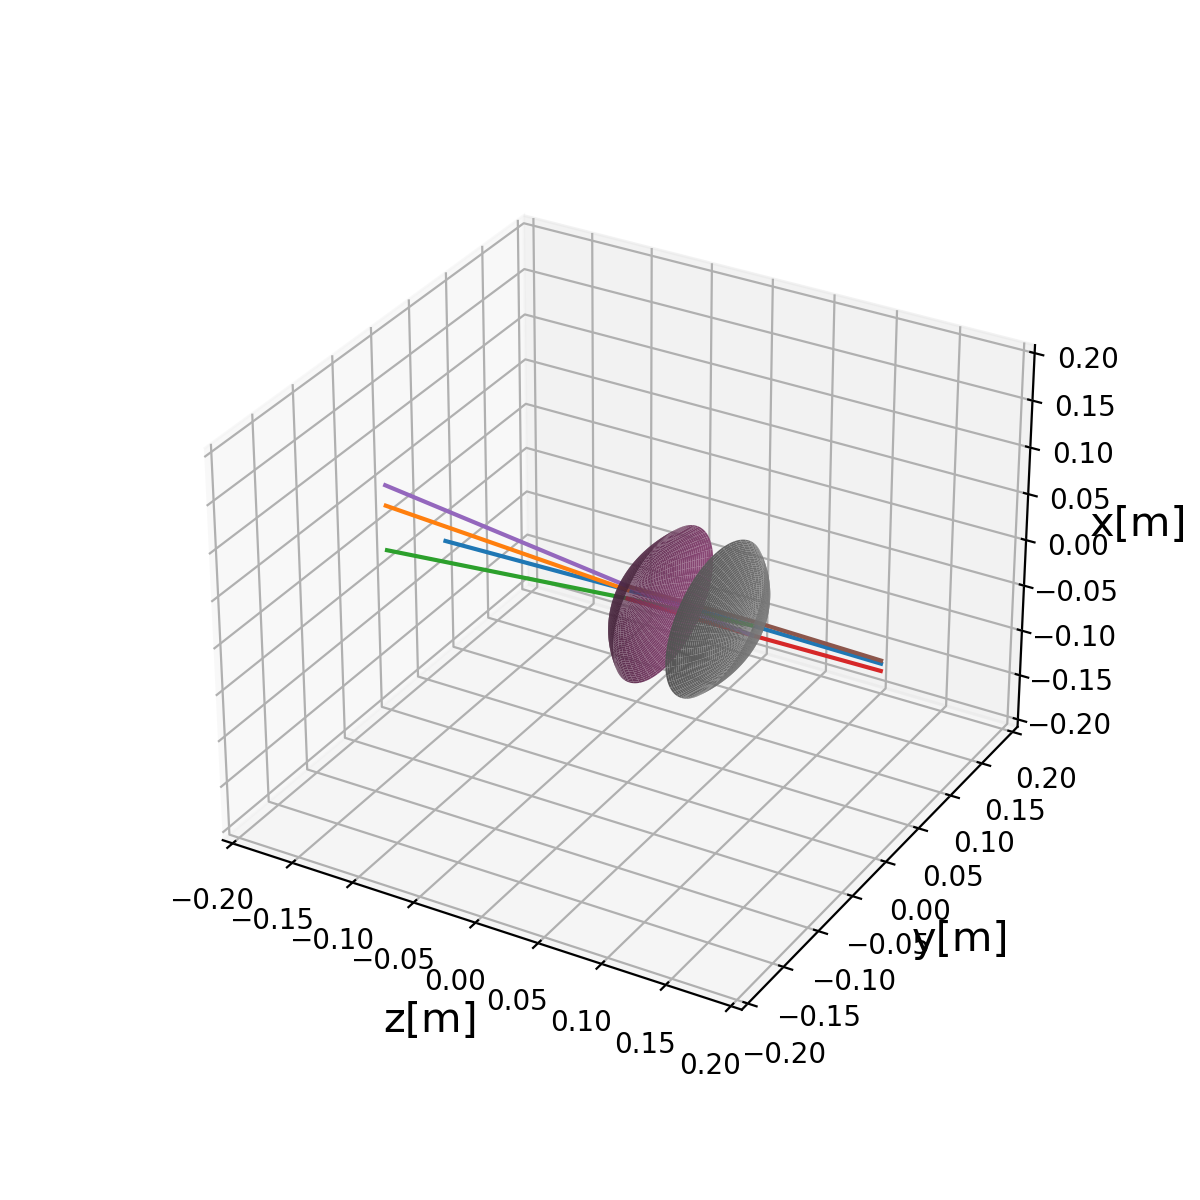

In [4]:
Simulation.refl_on = False 

sim = Simulation([[-0.2,0.2],[-0.2,0.2],[-0.2,0.2]]) #Simulation ([x bounds], [y bounds], [z bounds])
sim.add_ray([0,0,-0.15], [0.025, 0]) #args - (initial ray coords, [polar angle, azimuthal angle])

surf1 = Sphere(0.1, [0,0,0], -1, 1.45, np.pi/4) #args - (radius, vertex coords, half of sphere, refrac index, pol angle limit)
surf2 = Sphere(0.1, [0,0,0.1], 1, 1.45, np.pi/4)

sim.add_converging_lens(surf1, surf2) #args - surface obj, surface obj 

sim.run_sim()
sim.plot_sim()

<IPython.core.display.Javascript object>


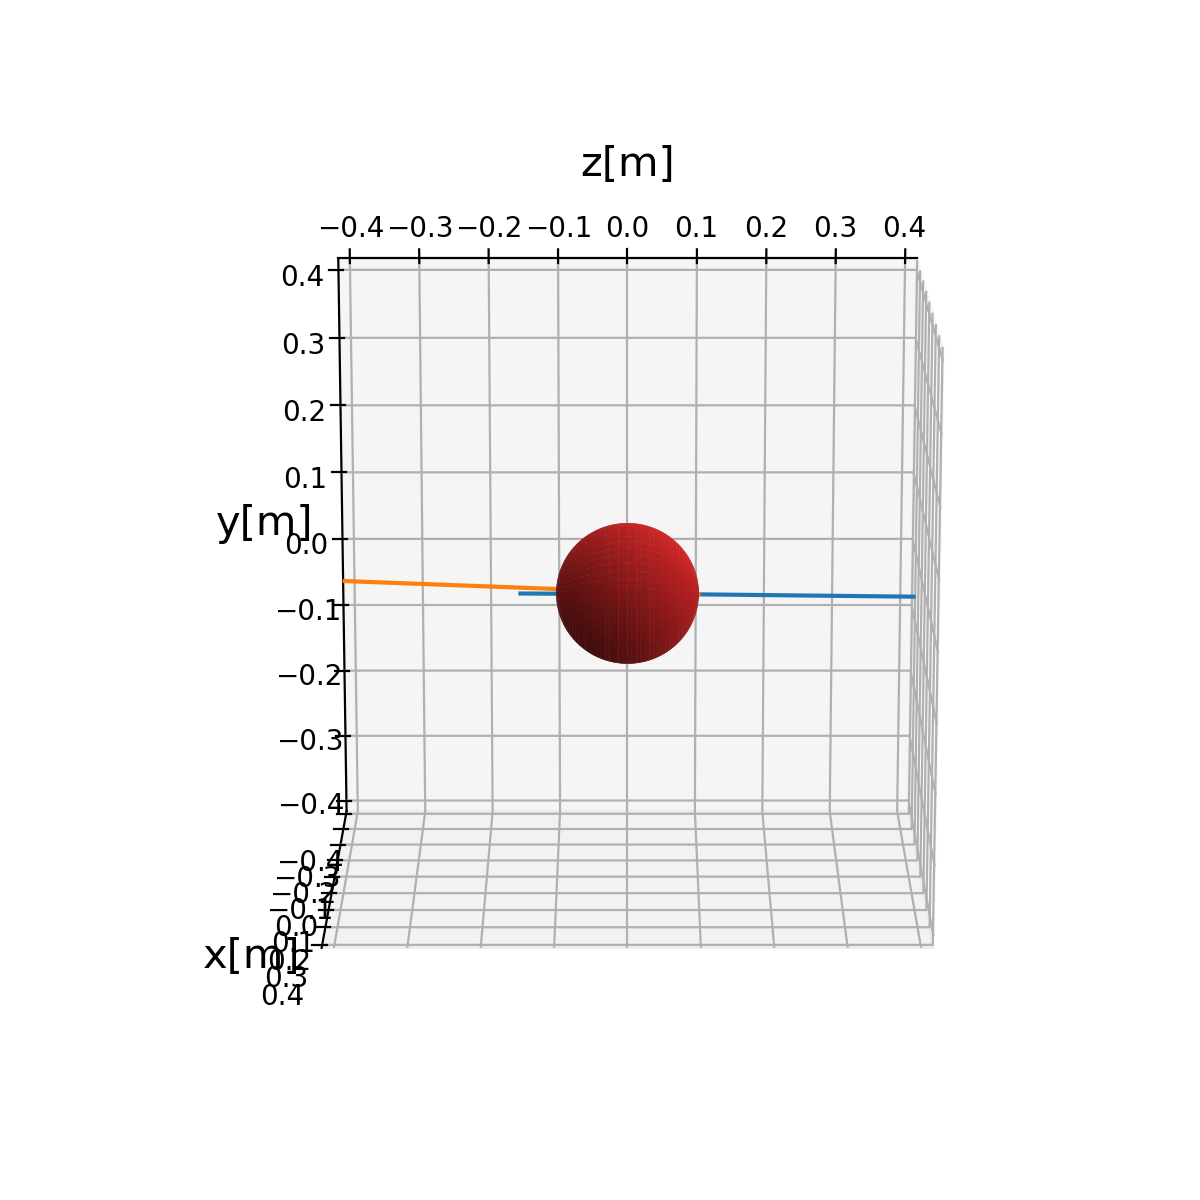

In [11]:
Simulation.refl_on = False 


sim = Simulation([[-0.4,0.4],[-0.4,0.4],[-0.4,0.4]])

sim.add_ray([0,0,-0.15], [0.025, 0])

surf1 = Sphere(0.05, [0,0,0.1], 1, 1.45, np.pi/2)
surf2 = Sphere(0.1, [0,0,0.1], 1, 1.45, np.pi)


sim.add_converging_lens(surf1, surf2) #args - surface obj, surface obj 

sim.run_sim()
sim.plot_sim()



